In [650]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle
import scipy as s

In [651]:
# Cart-pole parameters
g = 9.81

cart_width = 2
cart_height = 1
cart_density = 2 # kg/m^3
cart_mass = (cart_width*cart_height)*cart_density

pole_radius = 0.1
pole_length = 5
pole_density = 1
pole_mass = (np.pi*(pole_radius**2))*pole_length*pole_density

print(f"Cart mass: {cart_mass}kg")
print(f"Pole mass: {pole_mass}kg")

Cart mass: 4kg
Pole mass: 0.15707963267948966kg


In [652]:
# Dynamics model for cart-pole
# Dynamics equations from "R. Florian, 'Correct equations for the dynamics of the cart-pole system', Center for Cognitive and Neural Studies (Coneural), Cluj-Napoca, Romania (2005, updated 2007)"
# Note: the dynamics equations *without friction* (given in section 5, the conclusion) are used by this simulator.

class CartPoleDynamics:
    def __init__(self, cart_mass, pole_mass, pole_length):
        self.cart_mass = cart_mass
        self.pole_mass = pole_mass
        self.pole_length = pole_length
    
    # Returns omega_dot for a given theta and omega
    # u is the force on the cart
    def calc_angular_acceleration(self, theta, omega, u):
        inner = (-1*u - self.pole_mass*(self.pole_length / 2)*(omega**2)*np.sin(theta)) / (self.cart_mass + self.pole_mass)
        denom = (self.pole_length / 2) * ((4/3) - ((self.pole_mass * (np.cos(theta) ** 2))/(self.cart_mass + self.pole_mass)))
        omega_dot = (g*np.sin(theta) + np.cos(theta)*inner) / denom
        return omega_dot
    
    # Interesting that there's an omega_dot here
    # u is the force on the cart
    def calc_base_linear_acceleration(self, theta, omega, omega_dot, u):
        v_dot = (u + self.pole_mass*(self.pole_length / 2)*((omega**2)*np.sin(theta) - omega_dot*np.cos(theta))) / (self.cart_mass + self.pole_mass)
        return v_dot
    
    # States
    # x: position
    # v: velocity
    # theta: angle
    # omega: angular rate
    # u is the force on the cart
    # Note: angles are in radians!
    def grads(self, x, v, theta, omega, u):
        omega_dot = self.calc_angular_acceleration(theta, omega, u)
        v_dot = self.calc_base_linear_acceleration(theta, omega, omega_dot, u)
        return np.array([np.float64(v), np.float64(v_dot), np.float64(omega), np.float64(omega_dot)])

In [653]:
# Very simple rectangle-rule-based collocation

def parse_state(x, num_pts):
    dt = x[-1]
    out = x[:-1].reshape(5, num_pts)
    states = out[:4].T
    forces = out[-1]
    return states, forces, dt

# Get dynamics model, for constructing collocation constraints.
dynamics = CartPoleDynamics(cart_mass, pole_mass, pole_length)

# What is the collocation constraint?
# xk+1 = xk + f(xk, uk)dt
# => xk + f(xk, uk)dt - xk+1 = 0
# This will need to be encoded for each state, using the dynamics of the function.
# The constraints are provided as a list of callables, each one giving the constraint violation.
# This defines the dynamics collocation constraint between each pair of collocation points
def colloc_con_const(pt, num_pts):
    def con(x):
        states, forces, dt = parse_state(x, num_pts)
        
        state = states[pt]
        f = forces[pt]
        next_state = states[pt+1]

        return (state + dynamics.grads(*state, f)*dt - next_state)
    return con

# Function to define initial position constraint
def init_pos_const(x, num_pts):
    states, forces, dt = parse_state(x, num_pts)
    return states[0] - np.array(init_state)

# Function to define final position constraint
def final_pos_const(x, num_pts):
    states, forces, dt = parse_state(x, num_pts)
    return states[-1] - np.array(final_state)

# obj: objective function (function of the state, x)
# num_pts: number of collocation points in the transcription
def solve_cart_pole(obj, num_pts):
    # Define initial state
    # State contains x, v, theta, omega and force inputs for each collocation point + dt (segment length is part of the optimisation)
    # ===
    # Initial state guess based on linear interpolation between initial and final states
    xs = np.linspace(init_state[0], final_state[0], num_pts)
    vs = np.linspace(init_state[1], final_state[1], num_pts)
    thetas = np.linspace(init_state[2], final_state[2], num_pts)
    omegas = np.linspace(init_state[3], final_state[3], num_pts)
    # Initial control (force) at each point (zero-order hold)
    # (in collocation, the contol input is part of the state)
    us = np.ones(num_pts)
    # Initial value of dt
    dt0 = 0.1
    # This is the initial state. This is an interpolation between the start and end values for each of the four states,
    # plus control inputs, plus time.
    x0 = np.append(np.array([xs, vs, thetas, omegas, us]).flatten(), dt0)
    # print(x0)

    # Set up constraints (for enforcing dynamics)
    # ===
    constraints = [
        # Minimum dt constraint
        {'type': 'ineq', 'fun': lambda x: x[-1] - 0.01},
        {'type': 'eq', 'fun': lambda x: init_pos_const(x, num_pts)},
        {'type': 'eq', 'fun': lambda x: final_pos_const(x, num_pts)}
    ]
    # Add collocation constraints
    for pt in range(num_pts - 1):
        constraints.append({'type': 'eq', 'fun': colloc_con_const(pt, num_pts)})
    
    # Add bounds on control input (force)
    # ===
    max_u = 500
    min_u = -500
    # States + controls + time
    bounds = [(None, None)]*4*num_pts + [(min_u, max_u)]*num_pts + [(None, None)]

    # Solve!
    # ===
    res = s.optimize.minimize(obj, x0, args=(num_pts), method='slsqp', constraints=constraints, bounds=bounds, options={'disp': True, 'maxiter': 1000})

    return res, num_pts

# x, v, theta, omega
init_state = (0, 0, np.pi, 0)
final_state = (0, 0, 0, 0)

# Define objective - minimising time
def min_time_obj(x, num_pts):
    dt = x[-1]
    return dt   # All segments have the same duration, so minimising the trajectory time is the same as minimising dt.

## Tries to get to the top as quickly as possible and stay there
#def min_error_obj(x, num_pts):
#    states, us, dt = parse_state(x, num_pts)
#    # Tries to get to the final state as quickly as possible and stay there.
#    # The longer it stays there (the greater dt), the better.
#    return np.square(states - final_state).sum() - dt

# Returning num_pts unchanged here, just because it makes the downstream code easier. 
res, num_pts = solve_cart_pole(min_time_obj, 50)
# res, num_pts = solve_cart_pole(min_error_obj, 20)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.036120995621647674
            Iterations: 28
            Function evaluations: 7079
            Gradient evaluations: 28


Interesting observation: if the bounds on the control (force) are too restrictive, the optimiser fails to find a solution. This must be because it's unable to achieve the acceleration required to swing the pole past the horizontal.

In [654]:
# us are forces (control inputs)
states, us, dt = parse_state(res.x, num_pts)

# Interpolate
times = np.arange(num_pts)*dt

# State interpolation is linear between collocation points
xs, vs, thetas, omegas = states.T
x_interp = s.interpolate.make_interp_spline(times, xs, k=1)
v_interp = s.interpolate.make_interp_spline(times, vs, k=1)
theta_interp = s.interpolate.make_interp_spline(times, thetas, k=1)
omega_interp = s.interpolate.make_interp_spline(times, omegas, k=1)

state_interp = lambda t: np.array([x_interp(t), v_interp(t), theta_interp(t), omega_interp(t)])
# Control is zero-order hold
u_interp = s.interpolate.make_interp_spline(times, us, k=0)

MovieWriter ffmpeg unavailable; using Pillow instead.


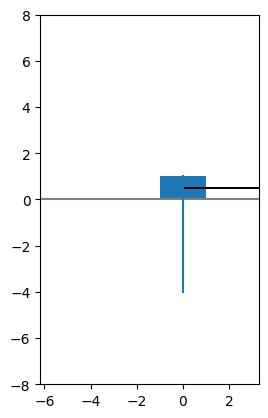

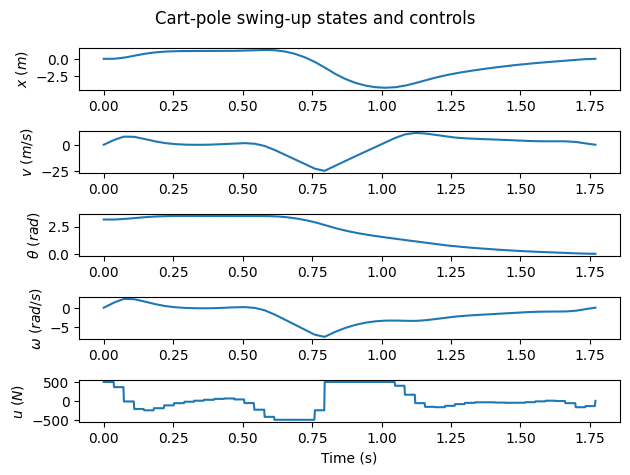

In [655]:
# x: position
# v: velocity
# theta: angle
# omega: angular rate
# us: forces (controls)

# animate
def animate(xs, thetas, us, save_path='./anim.gif', subsample=1):
    # Set up plot area
    anim_fig, anim_ax = plt.subplots()
    anim_ax.set_xlim(np.min(xs) - cart_width, np.max(xs) + cart_width)
    anim_ax.set_ylim(-8, 8)
    anim_ax.set_aspect('equal')

    x_init = xs[0]
    theta_init = thetas[0]

    # Plot runner
    anim_ax.axhline(0, c='grey')

    # Plot cart
    cart = anim_ax.add_patch(Rectangle((xs[0] - cart_width/2, 0), cart_width, cart_height))

    # Plot pole
    pole_base = np.array((x_init, cart_height))
    pole_tip = pole_base + np.array((pole_length*np.sin(theta_init), pole_length*np.cos(theta_init)))
    pole, = anim_ax.plot((pole_base[0], pole_tip[0]), (pole_base[1], pole_tip[1]))

    # Plot force
    force_arrow = anim_ax.arrow(x_init, cart_height/2, 0, 0, head_width=0.1, fc='black')
    
    def update(i):
        x = xs[i]
        theta = thetas[i]
        f = us[i]

        # Update cart
        cart.set_x(x-cart_width/2)

        # Update pole
        pole_base = np.array((x, cart_height))
        pole_tip = pole_base + np.array((pole_length*np.sin(theta), pole_length*np.cos(theta)))
        pole.set_data((pole_base[0], pole_tip[0]), (pole_base[1], pole_tip[1]))

        # Update arrow
        # Scale to reduce arrow size
        scale = 100
        force_arrow.set_data(x=x, y=cart_height/2, dx=f/scale, dy=0/scale)
    
    anim = FuncAnimation(anim_fig, update, np.arange(len(xs))[::subsample], interval=20)
    
    if save_path is not None: anim.save(save_path, fps=30)

    return anim

num_steps = 1000
anim_times = np.linspace(0, times[-1], num_steps)
xs = x_interp(anim_times)
vs = v_interp(anim_times)
thetas = theta_interp(anim_times)
omegas = omega_interp(anim_times)
us = u_interp(anim_times)

animate(xs, thetas, us, subsample=10)

# Create graphs
fig, axs = plt.subplots(5)
axs[0].plot(anim_times, xs)
axs[0].set_ylabel("$x$ ($m$)")
axs[1].plot(anim_times, vs)
axs[1].set_ylabel("$v$ ($m/s$)")
axs[2].plot(anim_times, thetas)
axs[2].set_ylabel(r"$\theta$ ($rad$)")
axs[3].plot(anim_times, omegas)
axs[3].set_ylabel(r"$\omega$ ($rad/s$)")
axs[4].plot(anim_times, us)
axs[4].set_ylabel("$u$ ($N$)")
axs[4].set_xlabel("Time (s)")
fig.suptitle("Cart-pole swing-up states and controls")
fig.tight_layout()
fig.savefig('./state_and_controls.png')

In [656]:
# Re-simulate with derived control inputs
# Use Scipy RK45 integrator for simulation

def dyn(t, x):
    # Get control input at time t (from collocation solution)
    u = u_interp(t)
    # Return gradients
    return dynamics.grads(*x, u)

# Same initial state as for the collocation
x0 = np.array(init_state)

# Final time (s)
T = times[-1]

sim_out = s.integrate.solve_ivp(dyn, [0, T], x0, dense_output=True)

MovieWriter ffmpeg unavailable; using Pillow instead.


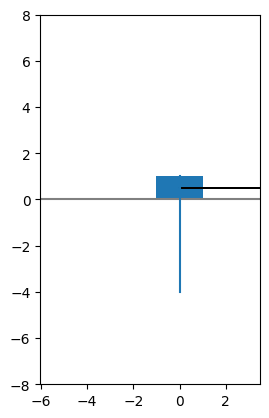

In [657]:
# Animate simulated solution
num_steps = 1000
anim_times = np.linspace(0, T, num_steps)
xs, vs, thetas, omegas = sim_out.sol(anim_times)
us = u_interp(anim_times)

animate(xs, thetas, us, './resim_anim.gif', subsample=10)

In the following code, we use a Taylor expansion to generate a linear approximation of the error dynamics about the reference trajectory:

$$\dot e(x,u) = \frac{\partial f}{\partial x}\Big|_{x_{ref}(t),u_{ref}(t)}(x-x_{ref}) + \frac{\partial f}{\partial u}\Big|_{x_{ref}(t),u_{ref}(t)}(u-u_{ref}) + \underbrace{\Phi_r(x,u)}_{\text{Remainder terms}}$$
$$\dot e(x,u) \approx A(t)(x-x_{ref}) + B(t)(u-u_{ref})$$

where $$\dot e := f(x,u)-f(x_{ref}, u_{ref}).$$


We may then solve the **differential ricatti equation**, $-\dot{P} = Q + P(t)A(t) + A(t)^\top P(t) - P(t)B(t) R^{-1} B(t)^\top P(t)$ backwards in time to get the trajectory of the matrix parameter $P(t)$.  From this we finally obtain the time varying state-feedback control law $u(t) = u_{ref} + K(t)(x-x_{ref})$, where $K(t)=-R^{-1} B(t)^\top P(t) x$.

It should be noted that effectiveness of the controller relies on the assumption that the remainder terms are dominated by the linearisation. In other words, the linearisation error must be sufficiently small 

Please see Seb East's lecture notes for more information about this.

In [658]:
# Tracking with LQR...
import casadi as ca # only using casadi here for symbolic differentiation to get the linearised dynamics
# Can also use jax, sympy, etc to linearise dynamics

x_sym = ca.SX.sym('x', 4)  # x, v, theta, omega
u_sym = ca.SX.sym('u')     # control input (force)

# re-define dynamics using casadi expressions
class CartPoleDynamics_casadi:
    def __init__(self, cart_mass, pole_mass, pole_length):
        self.cart_mass = cart_mass
        self.pole_mass = pole_mass
        self.pole_length = pole_length
    

    def calc_angular_acceleration(self, theta, omega, u):
        inner = (-1*u - self.pole_mass*(self.pole_length / 2)*(omega**2)*ca.sin(theta)) / (self.cart_mass + self.pole_mass)
        denom = (self.pole_length / 2) * ((4/3) - ((self.pole_mass * (ca.cos(theta) ** 2))/(self.cart_mass + self.pole_mass)))
        omega_dot = (g*ca.sin(theta) + ca.cos(theta)*inner) / denom
        return omega_dot

    def calc_base_linear_acceleration(self, theta, omega, omega_dot, u):
        v_dot = (u + self.pole_mass*(self.pole_length / 2)*((omega**2)*ca.sin(theta) - omega_dot*ca.cos(theta))) / (self.cart_mass + self.pole_mass)
        return v_dot

    def grads(self, x, v, theta, omega, u):
        omega_dot = self.calc_angular_acceleration(theta, omega, u)
        v_dot = self.calc_base_linear_acceleration(theta, omega, omega_dot, u)
        return ca.vertcat(v, v_dot, omega, omega_dot)
    

dynamics_casadi = CartPoleDynamics_casadi(cart_mass, pole_mass, pole_length)
f_sym = dynamics_casadi.grads(x_sym[0], x_sym[1], x_sym[2], x_sym[3], u_sym)

# get jacobian df/dx and df/du as functions of x and u
A_sym = ca.jacobian(f_sym, x_sym)
B_sym = ca.jacobian(f_sym, u_sym)

A_t = ca.Function('A_func', [x_sym, u_sym], [A_sym]) # convert to callable functions
B_t = ca.Function('B_func', [x_sym, u_sym], [B_sym])

In [659]:


def care(T, A_t, B_t, Q, R, Qf=None):
    if Qf is None: Qf = Q
    
    n = Q.shape[0]
    def care_ode(t, P_flat):
        P = P_flat.reshape(n,n)
        x = x_interp(t)
        u = u_interp(t)

        if type(A_t) == ca.Function:
            A = A_t(x, u).full()
        else:
            A = A_t(x, u)
        
        if type(B_t) == ca.Function:
            B = B_t(x, u).full()
        else:
            B = B_t(x, u)
        P_dot = (A.T @ P + P @ A - P @ B @ np.linalg.inv(R) @ B.T @ P + Q)
        return P_dot.flatten()
    
    # solve backwards in time
    P_T = Qf.flatten()
    sol = s.integrate.solve_ivp(care_ode, [0, T], P_T, method='RK45', dense_output=True)

    Ps = sol.y.T.reshape(-1,n,n)
    Ps = Ps[::-1]  # reverse time
    times = T-sol.t[::-1]
    P_interp = s.interpolate.make_interp_spline(times, Ps, k=2)

    def K(t):
        P = P_interp(t)
        x = x_interp(t)
        u = u_interp(t)
        
        if type(B_t) == ca.Function:
            B = B_t(x, u).full()
        else:
            B = B_t(x, u)
        K = np.linalg.inv(R) @ B.T @ P
        return K

    return P_interp, K

In [660]:
# T = 5
# # Testing the care solver with a simple linear system
# A_t = lambda x, u: np.array([[0, 1], [-1, 0]]) # care solver wants time-varying A and B, so we define them as functions of x(t) and u(t) (even though they're constant in this test case)
# B_t = lambda x, u: np.array([[0], [1]])

# P_interp, K_func = care(T, A_t, B_t, np.eye(2), 5*np.eye(1), Qf=10*np.eye(2))

# Ps = P_interp(np.linspace(0, T, 1000))
# plt.plot(np.linspace(0, T, 1000), Ps[:,0,0], label='P[0,0]', linewidth=1)
# plt.plot(np.linspace(0, T, 1000), Ps[:,0,1], label='P[0,1]', linewidth=1)
# plt.plot(np.linspace(0, T, 1000), Ps[:,1,1], label='P[1,1]', linewidth=1)
# plt.legend()
# plt.title("P(t) from CARE solution for test system")
# plt.xlabel("Time (s)")
# plt.ylabel("P(t) values")


In [661]:
# Re-simulate with derived control inputs
# Use Scipy RK45 integrator for simulation

T = times[-1]

# define LQR cost matrices
Q = np.diag([1, 1, 1, 1])   # state cost (assume same for terminal cost)
Qf = 10*np.diag([1, 1, 1, 1])
R = np.array([[0.1]])          # control cost
P, K = care(T, A_t, B_t, Q, R, Qf)

def dyn(t, x):
    # Get control input at time t (from collocation solution)
    u = u_interp(t) - K(t) @ (x - state_interp(t))  # add LQR feedback control
    # Return gradients
    return dynamics.grads(*x, u)

# Same initial state as for the collocation
x0 = np.array(init_state)
sol = s.integrate.solve_ivp(dyn, [0, T], x0, dense_output=True)


us_lqr = []
ts = []
for t in sol.t:
    ts.append(t)
    x = sol.sol(t)
    u = u_interp(t) - K(t) @ (x - state_interp(t))
    us_lqr.append(u)
us_lqr_interp = s.interpolate.make_interp_spline(ts, us_lqr, k=0)


/tmp/ipykernel_129783/862865645.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([np.float64(v), np.float64(v_dot), np.float64(omega), np.float64(omega_dot)])


MovieWriter ffmpeg unavailable; using Pillow instead.


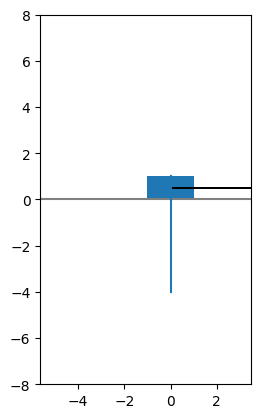

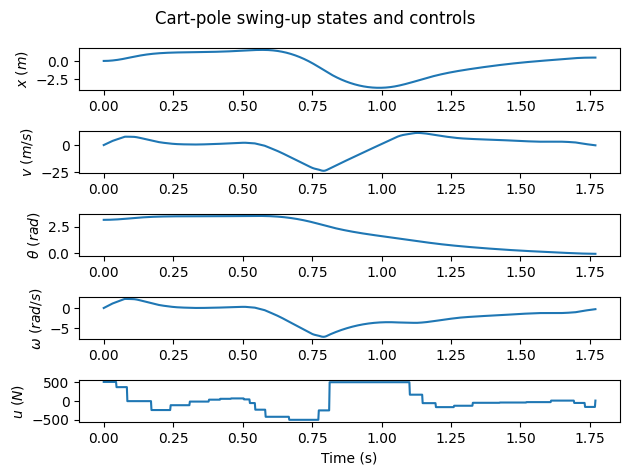

In [662]:
# Animate simulated solution
num_steps = 1000
anim_times = np.linspace(0, T, num_steps)
xs, vs, thetas, omegas = sol.sol(anim_times)


animate(xs, thetas, us, './resim_anim_lqr.gif', subsample=5)
us_lqr = us_lqr_interp(anim_times)
# Create graphs
fig, axs = plt.subplots(5)
axs[0].plot(anim_times, xs)
axs[0].set_ylabel("$x$ ($m$)")
axs[1].plot(anim_times, vs)
axs[1].set_ylabel("$v$ ($m/s$)")
axs[2].plot(anim_times, thetas)
axs[2].set_ylabel(r"$\theta$ ($rad$)")
axs[3].plot(anim_times, omegas)
axs[3].set_ylabel(r"$\omega$ ($rad/s$)")
axs[4].plot(anim_times, us_lqr)
axs[4].set_ylabel("$u$ ($N$)")
axs[4].set_xlabel("Time (s)")
fig.suptitle("Cart-pole swing-up states and controls")
fig.tight_layout()
fig.savefig('./state_and_controls_lqr.png')